# Model Fitting and visualizations

## Imports

In [1]:
#Imports
import h5py
import pandas as pd
import numpy as np
import seaborn as sns
import random
from keras.models import load_model
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score 
import itertools
from sklearn import metrics
from matplotlib import pyplot as plt

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

import tensorflow as tf
from tensorflow.keras.optimizers import Adam


## load data and spliting

In [2]:
X = np.load('Xdata.npy')
Y = np.load('Ydata.npy')

In [3]:
#Split data
X_train, X_rem, Y_train, Y_rem = train_test_split(X, Y, test_size = 0.4, random_state=5)
X_test, X_val, Y_test, Y_val = train_test_split(X_rem, Y_rem, test_size = 0.5, random_state=5)

## Create the model structure


In [4]:
# VGG16 MODEL
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense

vgg16_model = VGG16(include_top=False,
    weights="imagenet",
    input_shape=(100,100,3))

for layer in vgg16_model.layers:
    layer.trainable = False

x = vgg16_model.output
x = Dense(256, activation = "relu")(x)
x = Dropout(.2)(x)
x = Flatten()(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=vgg16_model.input, outputs=predictions)

In [5]:
#model summary
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)       0     

## Model specs 


In [6]:
epochs = 30
batch_size = 100
early_stopping = EarlyStopping(monitor='accuracy',
                                patience=2,
                                verbose=1 ,
                                min_delta=0.005,
                                mode='max')
init_lr = 1e-3   #learning rate for the optimizer
optimizer = Adam(learning_rate = init_lr)

In [7]:
model.compile(optimizer = optimizer , loss = "BinaryCrossentropy", metrics=["accuracy" , 'AUC', 'Precision', 'Recall'])

### *check if tensorflow work in gpu*

In [8]:
print("Num GPUs Available: ", len(tf.config.list_logical_devices('GPU')))

Num GPUs Available:  2


# Model fitting


In [9]:
with tf.device("/device:GPU:0"):
    history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, 
              validation_data = (X_val, Y_val), verbose = 1, callbacks=[early_stopping])

Epoch 1/30
303/303 [==============================] - 158s 517ms/step - loss: 0.5680 - accuracy: 0.7935 - auc: 0.8424 - precision: 0.8177 - recall: 0.8417 - val_loss: 0.4203 - val_accuracy: 0.8283 - val_auc: 0.8973 - val_precision: 0.8398 - val_recall: 0.8716
Epoch 2/30
303/303 [==============================] - 171s 565ms/step - loss: 0.3523 - accuracy: 0.8572 - auc: 0.9253 - precision: 0.8683 - recall: 0.8968 - val_loss: 0.4038 - val_accuracy: 0.8450 - val_auc: 0.9099 - val_precision: 0.8726 - val_recall: 0.8595
Epoch 3/30
303/303 [==============================] - 169s 559ms/step - loss: 0.3023 - accuracy: 0.8776 - auc: 0.9437 - precision: 0.8896 - recall: 0.9077 - val_loss: 0.3987 - val_accuracy: 0.8420 - val_auc: 0.9120 - val_precision: 0.8551 - val_recall: 0.8774
Epoch 4/30
303/303 [==============================] - 177s 585ms/step - loss: 0.2648 - accuracy: 0.8945 - auc: 0.9565 - precision: 0.9061 - recall: 0.9185 - val_loss: 0.3905 - val_accuracy: 0.8496 - val_auc: 0.9191 - val

# The Model performance:

- The Train accuracy = 96.85%
- The Train precision = 97.23%
- The Train recall = 97.49%
- The Valdiation accuracy = 84.43% 
- The Valdiation precision = 85.12%
- The Valdiation recall = 88.81%

## Some plots for the model outputs

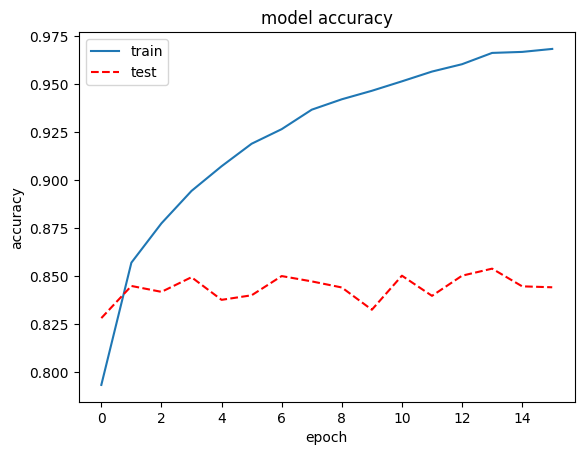

In [84]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'] , 'r' ,linestyle ='--')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


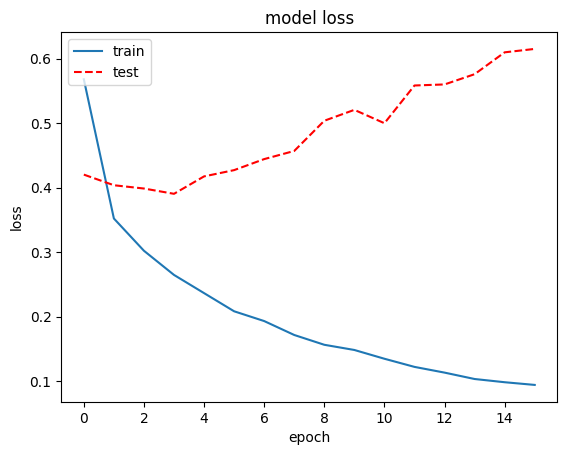

In [34]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'] , 'r' ,linestyle ='--')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Plot confusion matrix for train and test

In [85]:
def make_cf(data):
    data_pred = model.predict(data)
    for x in data_pred:
        if x[0] >= 0.5:
            x[0] = 1
        else:
            x[0] = 0
    cf = confusion_matrix(Y_train , y_train_pred)
    return cf

In [80]:
cf_train = make_cf(X_train)

947/947 [==============================] - 135s 143ms/step


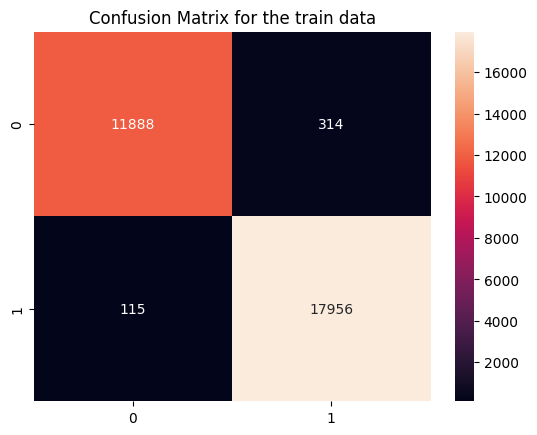

In [81]:
ax = sns.heatmap(cf_train, annot=True, fmt='d' ).set(title="Confusion Matrix for the train data")

In [82]:
cf_test = make_cf(X_test)

316/316 [==============================] - 47s 150ms/step


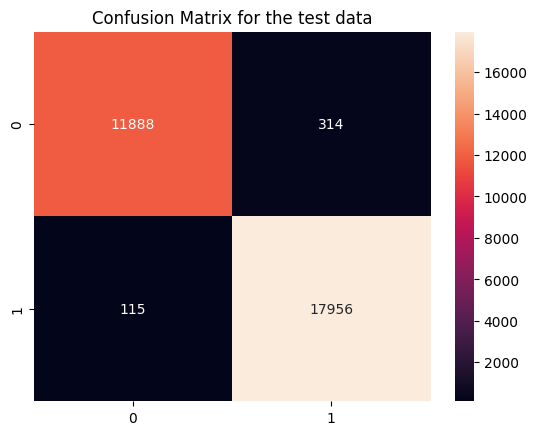

In [83]:
ax = sns.heatmap(cf_test, annot=True, fmt='d' ).set(title="Confusion Matrix for the test data")

# Evaluate model

In [93]:
result = model.evaluate(X_test, Y_test, verbose=1)
print('The accuarcy is' , round(result[1], 5)*100 , '%')

316/316 [==============================] - 50s 157ms/step - loss: 0.5953 - accuracy: 0.8529 - auc: 0.9142 - precision: 0.8680 - recall: 0.8882
The accuarcy is 85.294 %


# Save model

In [38]:
model.save('image_detector.h5')